In [2]:
# Source: http://brandonrose.org/clustering

import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
!pip install mpld3
import mpld3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 4.5 MB/s eta 0:00:00


In [41]:
# Get all the lists we need.
# Source: https://stackoverflow.com/a/24662707

import csv

with open('scraped_pattern_data_gofpatterns_revised.csv', newline='') as f:
    reader = csv.reader(f)
    list_gof = list(reader)
    list_gof.pop(0)
    list_gof = np.array(list_gof)
    id_gof = list_gof[:,0]
    cat_gof = list_gof[:,1]
    name_gof = list_gof[:,2]
    overview_gof = list_gof[:,3]

print(name_gof)

['abstract_factory_pattern' 'decorator_pattern' 'facade_pattern'
 'composite_pattern' 'factory_method_pattern' 'prototype_pattern'
 'adapter_pattern' 'builder_pattern' 'singleton_pattern' 'bridge_pattern'
 'flyweight_pattern' 'proxy_pattern' 'memento_pattern'
 'interpreter_pattern' 'iterator_pattern' 'observer_pattern'
 'command_pattern' 'mediator_pattern' 'chain_of_responsibility'
 'state_pattern' 'template_pattern' 'hierarchical_visitor_pattern'
 'strategy_pattern']


In [6]:
# load nltk's English stopwords as variable called 'stopwords'
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [8]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [24]:
nltk.download('punkt')

#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in overview_gof:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 5759 items in vocab_frame


In [26]:
print(vocab_frame.head())
print
print
print
print

             words
question  question
what          what
is              is
the            the
abstract  abstract


<function print>

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(overview_gof) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 196 ms, sys: 522 µs, total: 196 ms
Wall time: 220 ms
(23, 83)


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [28]:
terms = tfidf_vectorizer.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

<function print>

In [31]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 71.4 ms, sys: 300 µs, total: 71.7 ms
Wall time: 51.1 ms


In [44]:
#!pip install sklearn
#from sklearn.externals import joblib
#import sklearn.external.joblib as extjoblib
import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters_gof = km.labels_.tolist()

In [47]:
patterns_gof = { 'id': id_gof, 'cat': cat_gof, 'name': name_gof, 'overview': overview_gof, 'cluster': clusters_gof }

frame_gof = pd.DataFrame(patterns_gof, index = [clusters] , columns = ['id', 'cat', 'name', 'cluster'])

In [48]:
frame_gof['cluster'].value_counts() #number of patterns per cluster (clusters from 0 to 2)

0    16
1     5
2     2
Name: cluster, dtype: int64

In [49]:
grouped = frame_gof['id'].groupby(frame_gof['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average id per cluster

cluster
0    5.745587e+38
1    2.022062e+13
2    4.705650e+04
Name: id, dtype: float64

In [53]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame_gof.loc[i]['name'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'class', b'interface', b'creating', b'abstract', b'implementation', b'method',

Cluster 0 titles: abstract_factory_pattern, decorator_pattern, facade_pattern, factory_method_pattern, prototype_pattern, adapter_pattern, builder_pattern, singleton_pattern, bridge_pattern, proxy_pattern, interpreter_pattern, iterator_pattern, command_pattern, mediator_pattern, chain_of_responsibility, template_pattern,

Cluster 1 words: b'state', b'behavior', b'change', b'dependent', b'application', b'defines',

Cluster 1 titles: flyweight_pattern, memento_pattern, observer_pattern, state_pattern, strategy_pattern,

Cluster 2 words: b'composite', b'structures', b'represented', b'operations', b'need', b'allows',

Cluster 2 titles: composite_pattern, hierarchical_visitor_pattern,





In [55]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [56]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

#set up cluster names using a dict
cluster_names = {0: 'cluster 0', 
                 1: 'cluster 1', 
                 2: 'cluster 2'}

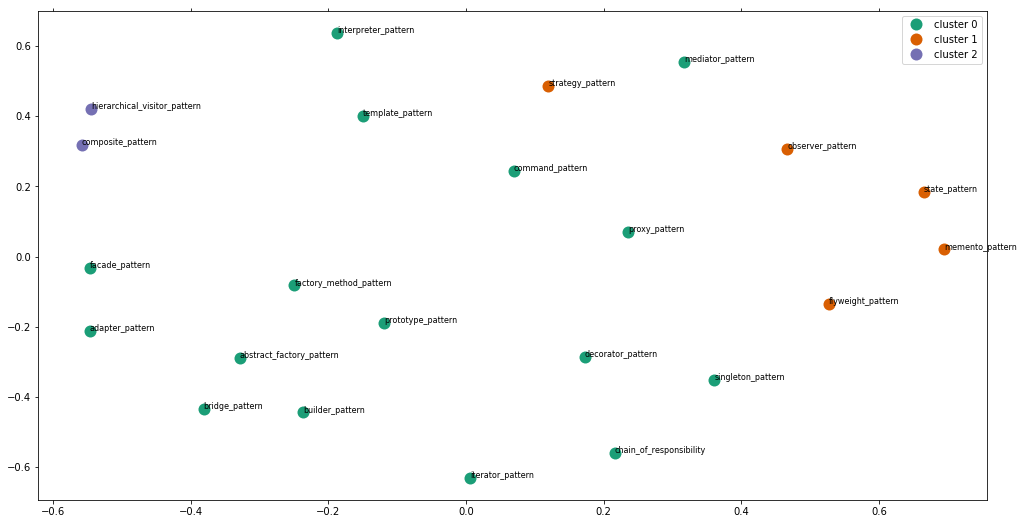

<Figure size 432x288 with 0 Axes>

In [59]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_gof = pd.DataFrame(dict(x=xs, y=ys, label=clusters, name=name_gof)) 

#group by cluster
groups = df_gof.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df_gof)):
    ax.text(df_gof.loc[i]['x'], df_gof.loc[i]['y'], df_gof.loc[i]['name'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)

In [60]:
plt.close()

In [61]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [77]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df_gof = pd.DataFrame(dict(x=xs, y=ys, label=clusters, name=name_gof)) 

#group by cluster
groups = df_gof.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.name]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
html = mpld3.fig_to_html(fig)
#print(html)

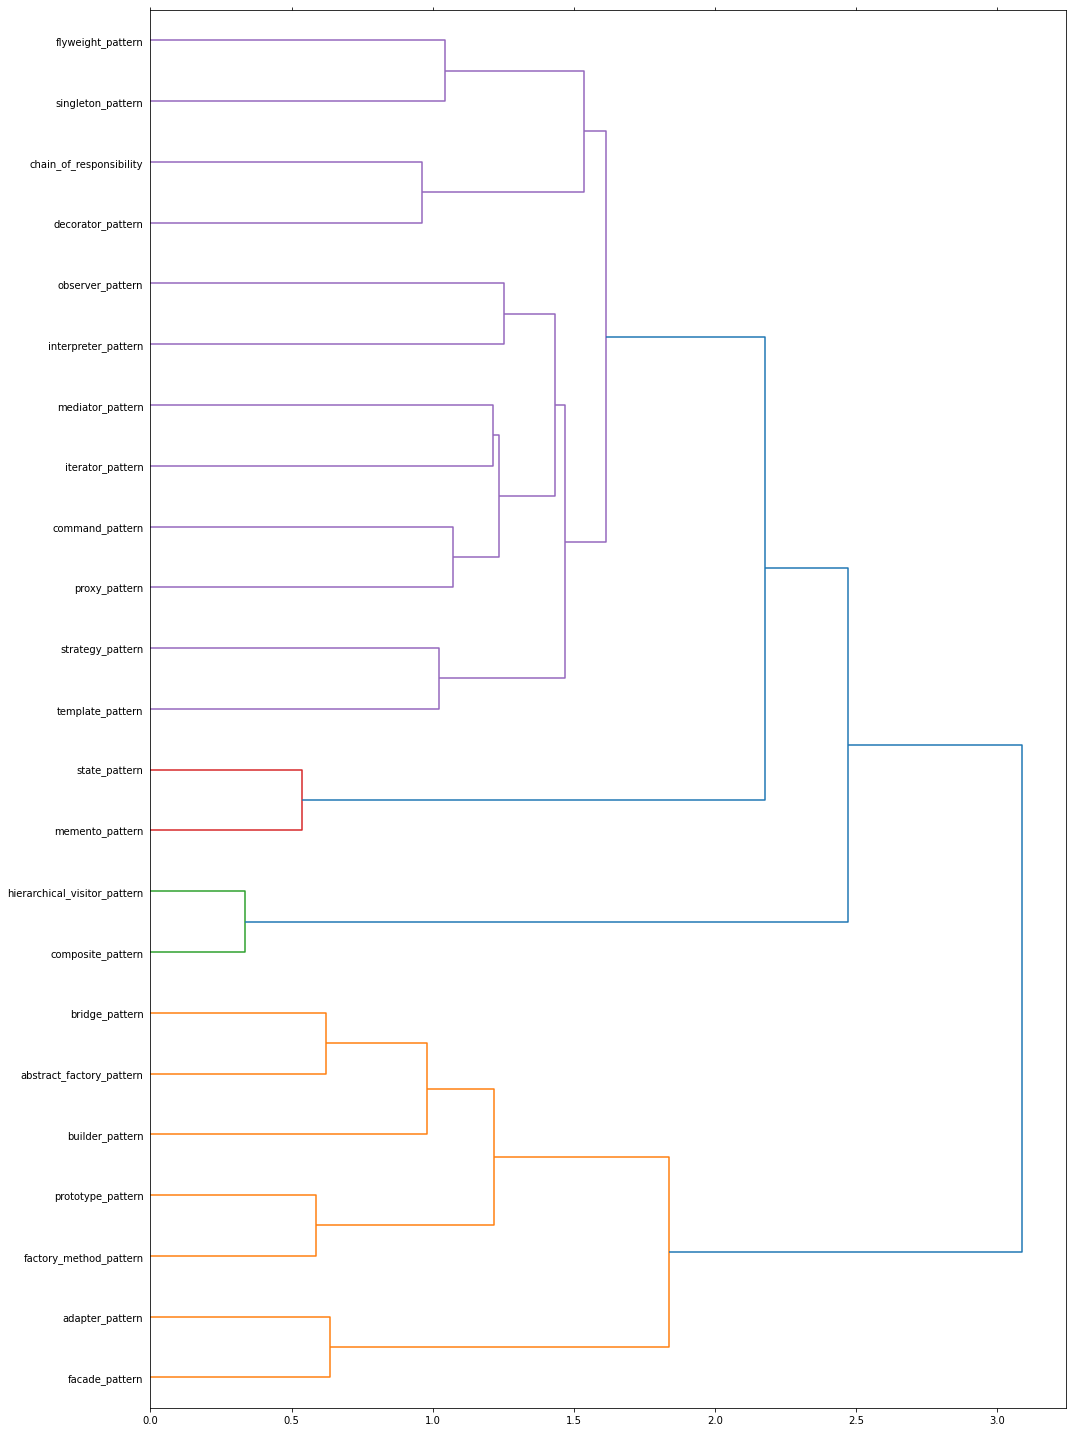

In [64]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=name_gof);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [65]:
plt.close()

In [66]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [67]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [69]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in overview_gof]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 56.9 ms, sys: 762 µs, total: 57.7 ms
Wall time: 57.9 ms
CPU times: user 79 ms, sys: 0 ns, total: 79 ms
Wall time: 78.6 ms
CPU times: user 8.68 ms, sys: 0 ns, total: 8.68 ms
Wall time: 8.49 ms


In [70]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [72]:
%time lda = models.LdaModel(corpus, num_topics=3, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 2.49 s, sys: 50 ms, total: 2.54 s
Wall time: 2.51 s


In [73]:
lda.show_topics()

[(0,
  '0.035*"class" + 0.022*"creat" + 0.016*"factori" + 0.013*"implement" + 0.012*"method" + 0.012*"interfac" + 0.012*"subclass" + 0.010*"client" + 0.009*"new" + 0.009*"without"'),
 (1,
  '0.027*"interfac" + 0.025*"class" + 0.015*"one" + 0.014*"state" + 0.014*"composit" + 0.014*"instanc" + 0.014*"subsystem" + 0.011*"need" + 0.010*"system" + 0.010*"provid"'),
 (2,
  '0.032*"class" + 0.030*"construct" + 0.027*"abstract" + 0.020*"implement" + 0.018*"complex" + 0.015*"represent" + 0.015*"differ" + 0.013*"separ" + 0.013*"creat" + 0.010*"step"')]

In [76]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

<ipython-input-76-e07b68064581>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  topics_matrix = np.array(topics_matrix)


IndexError: ignored